<a href="https://colab.research.google.com/github/logicalschema/data620/blob/main/Project%203/Data_620_Project_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data 620 Project 3

[Github Link](https://github.com/logicalschema/data620/tree/main/Project%203/)

[YouTube Video](https://youtu.be/HqvhHvftVs4)  

<img src=https://github.com/logicalschema/data620/raw/main/Project%203/data/gender.jpg width="150">

## Assignment
Using any of the three classifiers described in chapter 6 of Natural Language Processing with Python, and any features you can think of, build the best name gender classifier you can. Begin by splitting the Names Corpus into three subsets: 500 words for the test set, 500 words for the dev-test set, and the remaining 6900 words for the training set. Then, starting with the example name gender classifier, make incremental improvements. Use the dev-test set to check your progress. Once you are satisfied with your classifier, check its final performance on the test set. How does the performance on the test set compare to the performance on the dev-test set? Is this what you'd expect?

Project is due 4/11.

Source: *Natural Language Processing with Python*, exercise 6.10.2.


# Setup of Libraries and Some Functions

In [153]:
# NLTK and the names corpus
import nltk
from nltk.corpus import names
from nltk.classify import apply_features

# For calling files from urls
import urllib

# Pandas dataframe
import pandas as pd

# Used for matrices
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Called for displaying html and for this project displaying dataframes side by side
from IPython.display import display_html

# Used for regular expressions 
import re

# Used for splitting the data into three groups devtest, test, and training
from sklearn.model_selection import train_test_split
nltk.download('names')

# gender_features is a function that returns the last letter of the string variable
def gender_features(word):
  return {'last_letter': word[-1]}

# https://codereview.stackexchange.com/questions/224177/python-function-to-count-syllables-in-a-word
# Function counts the number of syllables in a word
def count_syllables(word):
    return len(
        re.findall('(?!e$)[aeiouy]+', word, re.I) +
        re.findall('^[^aeiouy]*e$', word, re.I)
    )

# Function for displaying dataframes side by side
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

# Variable to keep track of figures
fig_no = 1

[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Package names is already up-to-date!


# Data
The data being used is from the `NLTK` corpus. Each name is classified with a gender. 

In [154]:
nltk.download('names')
names.fileids() 

[nltk_data] Downloading package names to /root/nltk_data...
[nltk_data]   Package names is already up-to-date!


['female.txt', 'male.txt']

In [155]:
# Labeled names contains all of the data as tuples with male or female as the second field
labeled_names = ([(name.lower(), 'male') for name in names.words('male.txt')] + [(name.lower(), 'female') for name in names.words('female.txt')])


# Individual male and female variables and lowercase the name
males = []
females = []
for name in names.words('male.txt'):
  males.append(name.lower())

for name in names.words('female.txt'):
  females.append(name.lower())


# Print snippets of each variable
print("Here is a snippet of the labeled_names variable: " + str(labeled_names[0:10]))
print("Here is a snippet of female names variable: " + str(females[0:10]))
print("Here is a snippet of male names variable: " + str(males[0:10]) + "\n")

# Additional Information about the data
print("There are " + str(len(labeled_names)) + " total names.")
print("There are " + str(len(females)) + " female names.")
print("There are " + str(len(males)) + " male names.")

Here is a snippet of the labeled_names variable: [('aamir', 'male'), ('aaron', 'male'), ('abbey', 'male'), ('abbie', 'male'), ('abbot', 'male'), ('abbott', 'male'), ('abby', 'male'), ('abdel', 'male'), ('abdul', 'male'), ('abdulkarim', 'male')]
Here is a snippet of female names variable: ['abagael', 'abagail', 'abbe', 'abbey', 'abbi', 'abbie', 'abby', 'abigael', 'abigail', 'abigale']
Here is a snippet of male names variable: ['aamir', 'aaron', 'abbey', 'abbie', 'abbot', 'abbott', 'abby', 'abdel', 'abdul', 'abdulkarim']

There are 7944 total names.
There are 5001 female names.
There are 2943 male names.


## Problems with Data: Unisex Names

There was a problem that arose with the data. Some of the names are unisex names and classified as both male and female. I decided to remove these names from the data before training. The next steps build sets from the `males` and `females` variables, finds their intersection, and then removes them from the variables. Though this approach maybe controversial, I will reuse the unisex names at the end. 

In [156]:
# Convert the male and female lists to sets
maleSet = set(males)
femaleSet = set(females)

# The intersection of the two sets are the unisex names
unisexSet = maleSet.intersection(femaleSet) 

# Update the sets by removing the unisex names
maleSet = maleSet.difference(unisexSet)
femaleSet = femaleSet.difference(unisexSet)

print("Snippet of unisex names: " + str(list(unisexSet)[:10]))


Snippet of unisex names: ['van', 'page', 'ginger', 'deane', 'sibyl', 'frank', 'christie', 'heath', 'maurise', 'dennie']


I recreate the variables and save the unisex names for a later use.

In [157]:
# Recreate the variables
males = list(maleSet)
females = list(femaleSet)
unisex = list(unisexSet)

for name in unisex:
  # Remove all elements that match the male or female of the unisex name in labeled_names
  labeled_names = list(filter(lambda element: element != (name, 'female'), labeled_names))
  labeled_names = list(filter(lambda element: element != (name, 'male'), labeled_names))

# Remove any duplicates in labeled_names
tempSet = set(labeled_names)
labeled_names = list(tempSet)

# Print snippets of each variable
print("Here is a snippet of the labeled_names variable: " + str(labeled_names[0:10]))
print("Here is a snippet of female names variable: " + str(females[0:10]))
print("Here is a snippet of male names variable: " + str(males[0:10]) + "\n")

# Additional Information about the data
print("There are " + str(len(females)) + " female names.")
print("There are " + str(len(males)) + " male names.")
print("There are " + str(len(unisex)) + " unisex names.")
print("There are " + str(len(labeled_names)) + " in labeled_names.")

Here is a snippet of the labeled_names variable: [('charlott', 'female'), ('tove', 'female'), ('tersina', 'female'), ('malkah', 'female'), ('nickey', 'male'), ('jordanna', 'female'), ('cleva', 'female'), ('sarina', 'female'), ('alli', 'female'), ('selene', 'female')]
Here is a snippet of female names variable: ['clementine', 'roch', 'aggie', 'dorit', 'lilia', 'jeri', 'fania', 'gray', 'elisabetta', 'idell']
Here is a snippet of male names variable: ['sig', 'aleks', 'tomkin', 'georg', 'flipper', 'wilburn', 'burton', 'konrad', 'timothee', 'desmund']

There are 4633 female names.
There are 2578 male names.
There are 365 unisex names.
There are 7211 in labeled_names.


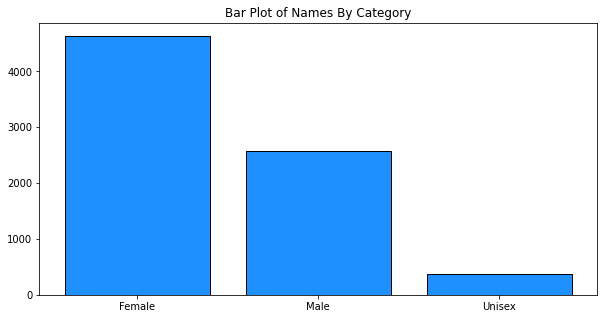

In [158]:
categories = ['Female', 'Male', 'Unisex']
counts = [len(females), len(males), len(unisex)]

plt.figure(fig_no,figsize=(10,5)) 
plt.title('Bar Plot of Names By Category')
plt.bar(categories, counts, color='dodgerblue', edgecolor='black')
plt.savefig('Figure ' + str(fig_no) + '.png')
fig_no +=1

In [159]:
# Sample of labeled_names
print(labeled_names[0:10])
print("There are " + str(len(labeled_names)) + " names.")

[('charlott', 'female'), ('tove', 'female'), ('tersina', 'female'), ('malkah', 'female'), ('nickey', 'male'), ('jordanna', 'female'), ('cleva', 'female'), ('sarina', 'female'), ('alli', 'female'), ('selene', 'female')]
There are 7211 names.


## Classifiers for the Data

I found Anne Fredrickson's [Phonological Cues to Gender in Sex-Typed and Unisex Names](https://www.swarthmore.edu/sites/default/files/assets/documents/linguistics/2007_fredrickson_annie.pdf) online and saw the following table that provides gender cues for names. I was not able to calculate open and closed syllables, but I thought this was a good start to look at the data.

<img src=https://github.com/logicalschema/data620/raw/main/Project%203/data/gendercues.png width="400">

In [160]:
# create dataframe using labeled_names
df = pd.DataFrame(labeled_names, columns =['Name', 'Gender'])

# Snippet of the df dataframe
df.head(5)

# Drop NA
df.dropna()

,Name,Gender
0,charlott,female
1,tove,female
2,tersina,female
3,malkah,female
4,nickey,male
...,...,...
7206,gipsy,female
7207,britani,female
7208,ruthe,female
7209,hallie,female


# Splitting the DataFrame
I split the data into three subsets: 500 for the test set, 500 for dev-test, and the remainder for the training set. I accomplish this by calling `train_test_split` two times.

In [161]:
# Split the original data into two groups 1,000 for the test and the remainder for training
# The 1,000 test set will then be split into dev-test and test groups
train, testing = train_test_split(df, test_size=1000, random_state=4221, stratify=df[['Gender']])
devtest, test = train_test_split(testing, test_size=500, random_state=4222, stratify=testing[['Gender']])

display_side_by_side(train.head(5), devtest.head(5), test.head(5))

,Name,Gender
6685,rina,female
2360,alexine,female
5154,janice,female
1848,misti,female
5504,tatiana,female
,Name,Gender
1739,ardelia,female
5741,min,female
471,eveline,female
5567,kenna,female


# Training Data and Models

## Gender Percentage by Last Letter
In the study listed above as well as the textbook, they noted the significance of the last letter. This section looks at some analysis of the last letter and gender.

In [162]:
# Get list of unique last letters of each name
letters = set([])
for index, row in train.iterrows():
  if row['Name'][-1].isalpha():
    letters.add(row['Name'][-1])

# Convert letters to a list and sort it
letters = list(letters)
letters.sort()

# Create a quick dictionary to tally genders by last letter
letterGenders = {}
for letter in letters:
  letterGenders[letter] = {'male': 0, 'female': 0}
  subset = train[train['Name'].str[-1] == letter]
  freq = subset.groupby('Gender').size().reset_index(name='counts')
  if 'male' in freq.values:
    letterGenders[letter]['male'] = freq.query('Gender == "male"')['counts'].iloc[0]
  if 'female' in freq.values:
    letterGenders[letter]['female'] = freq.query('Gender == "female"')['counts'].iloc[0]

# Convert values to percentages
for key in letterGenders.keys():
  total = letterGenders[key]['male'] + letterGenders[key]['female']
  letterGenders[key]['male'] = (letterGenders[key]['male'] / total) * 100
  letterGenders[key]['female'] = (letterGenders[key]['female'] / total) * 100


### Visualization of Gender by the Last Letter
After compiling the data from the training set for the last letter and gender, the following is a visualization. There is a significance to the last letter being "a" and female classification for a name.


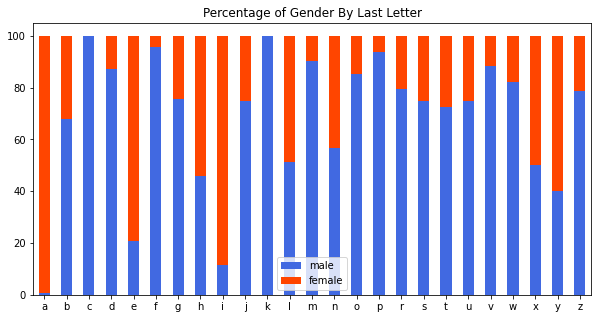

In [163]:
letterGendersDF = pd.DataFrame.from_dict(letterGenders, orient='index')
letterGendersDF.head(5)
letterGendersDF.plot.bar(stacked=True, rot=0, color={"male": "royalblue", "female": "orangered"}, figsize=(10,5))
plt.title('Percentage of Gender By Last Letter')
plt.savefig('Figure ' + str(fig_no) + '.png')
fig_no +=1


### First Iteration: Using the Last Letter
The 1st iteration of the model uses the last letter as was used in the textbook.

*   Last Letter of Name




In [164]:
# Modified Feature Set to use last letter
trainsets = []
for index, row in train.iterrows():
  temp = gender_features(row['Name'])
  x = ( temp, row['Gender'] )
  trainsets.append(x)

print(trainsets[:10])

# The training set is used to train a new "naive Bayes" classifier.
classifier = nltk.NaiveBayesClassifier.train(trainsets)

# Top 10 Informative Features
classifier.show_most_informative_features(10)


[({'last_letter': 'a'}, 'female'), ({'last_letter': 'e'}, 'female'), ({'last_letter': 'e'}, 'female'), ({'last_letter': 'i'}, 'female'), ({'last_letter': 'a'}, 'female'), ({'last_letter': 'e'}, 'female'), ({'last_letter': 'r'}, 'male'), ({'last_letter': 'n'}, 'female'), ({'last_letter': 'a'}, 'female'), ({'last_letter': 'e'}, 'female')]
Most Informative Features
             last_letter = 'a'            female : male   =     68.0 : 1.0
             last_letter = 'f'              male : female =     28.1 : 1.0
             last_letter = 'p'              male : female =     18.5 : 1.0
             last_letter = 'm'              male : female =     15.3 : 1.0
             last_letter = 'd'              male : female =     11.9 : 1.0
             last_letter = 'v'              male : female =     11.1 : 1.0
             last_letter = 'o'              male : female =     10.3 : 1.0
             last_letter = 'w'              male : female =      7.4 : 1.0
             last_letter = 'r'     

In [165]:
# Run the classifier with the dev_test set
devtestsets = []
for index, row in devtest.iterrows():
  temp = gender_features(row['Name'])
  x = ( temp, row['Gender'] )
  devtestsets.append(x)

We get the following for the accuracy for the `devtest` set. We will continue to refine the classifiers.

In [166]:
# Print the accuracy for the devtest set
print(nltk.classify.accuracy(classifier, devtestsets))

0.788


## Female Gender Percentage by the Last Two Letters
Let's take a look at the feature of grabbing the last two letters of the first name. We will start by constructing a `Numpy` matrix that is initialized with zeroes and by grabbing a set of unique pairs of the last two letters from the training set.

In [167]:
# Create list of letters
letters = [chr(x) for x in range(ord('a'), ord('z') + 1)]

# Create a dictionary for mapping
lookup_letters = {}
index = 0
for letter in letters:
  lookup_letters[letter] = index
  index += 1

# Create a numpy matrix 0 to 25 (a-z)
index = len(letters)
matrix = np.zeros(shape=(index, index))


# Get list of the unique last two letters of each name
strings = set([])
for index, row in train.iterrows():
  temp = ""
  if row['Name'][-2].isalpha():
    temp = temp + row['Name'][-2]
  if row['Name'][-1].isalpha():
    temp = temp + row['Name'][-1]
  if len(temp) == 2:
    strings.add(temp)


strings = list(strings)
strings.sort()

#Snippet of last two letters
print(strings[:10])

# Length of the two letter strings
print(len(strings))


['ab', 'ac', 'ad', 'ae', 'af', 'ag', 'ah', 'ai', 'aj', 'ak']
260


Next, I will fill the matrix with the probabilities of females with regards to the letter pair groupings. The ratios will be used to construct a heatmap with the matrix.

In [168]:
# Probability of women by two letters dictionary
probFemaleTwoLetters = {}
temp_m = 0
temp_f = 0

# Compile probabilities: females/total for the group
for string in strings:
  probFemaleTwoLetters[string] = 0
  subset = train[train['Name'].str[-2:] == string]
  freq = subset.groupby('Gender').size().reset_index(name='counts')

  if 'male' in freq.values:
    temp_m = freq.query('Gender == "male"')['counts'].iloc[0]
  if 'female' in freq.values:
    temp_f = freq.query('Gender == "female"')['counts'].iloc[0]
  
  probFemaleTwoLetters[string] = temp_f / (temp_m + temp_f)

# Fill the matrix with the probabilities for females of the two letters
for string in strings:
  x = lookup_letters[string[0]]
  y = lookup_letters[string[1]]
  matrix[x][y] = probFemaleTwoLetters[string]

### Visualization of the Female Probabilities by the Last Two Letters
After compiling data using the training set, the following is a visualization of the probability of a female classification for a name given the last two letters. The x-axis denotes the 1st letter and the y-axis denotes the second letter. Because of the high probabilities displayed, the last two letters looks like a good feature to add.

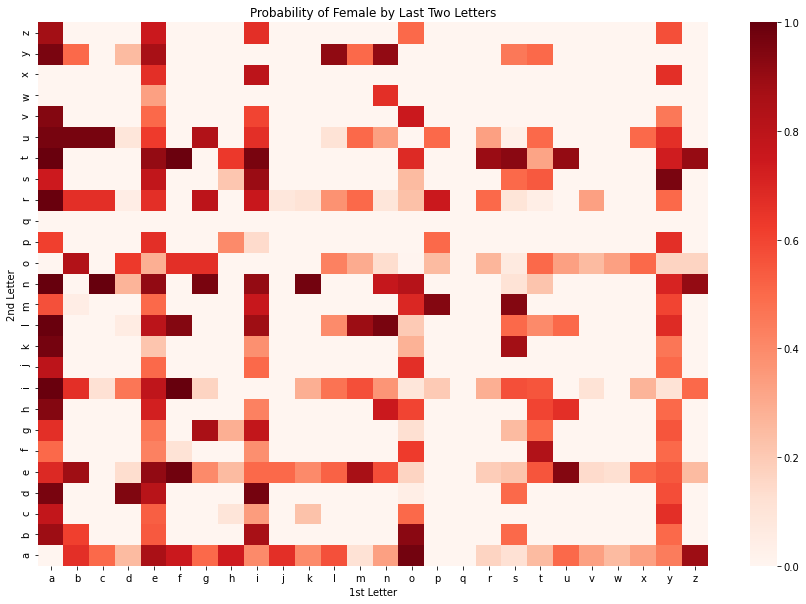

In [169]:
x_axis_labels = letters
y_axis_labels = letters
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(matrix, xticklabels=x_axis_labels, yticklabels=y_axis_labels, vmin=0, vmax=1, cmap='Reds')
ax.invert_yaxis()
ax.set(xlabel='1st Letter', ylabel='2nd Letter')
plt.title('Probability of Female by Last Two Letters')
plt.savefig('Figure ' + str(fig_no) + '.png')
fig_no +=1


### Second Iteration: Last Letter and Last Two Letters
Let's construct a new model using the features: 

*   Last Letter of the Name
*   Last Two Letters of the Name




In [170]:
# Modified Feature Set to use both the last letter and the last two letters
trainsets = []
for index, row in train.iterrows():
  temp = gender_features(row['Name'])
  temp['last_twoletters'] = row['Name'][-2:]
  x = ( temp, row['Gender'] )
  trainsets.append(x)

print(trainsets[:10])

# The training set is used to train a new "naive Bayes" classifier.
classifier = nltk.NaiveBayesClassifier.train(trainsets)

# Top 10 Informative Features
classifier.show_most_informative_features(10)


[({'last_letter': 'a', 'last_twoletters': 'na'}, 'female'), ({'last_letter': 'e', 'last_twoletters': 'ne'}, 'female'), ({'last_letter': 'e', 'last_twoletters': 'ce'}, 'female'), ({'last_letter': 'i', 'last_twoletters': 'ti'}, 'female'), ({'last_letter': 'a', 'last_twoletters': 'na'}, 'female'), ({'last_letter': 'e', 'last_twoletters': 'te'}, 'female'), ({'last_letter': 'r', 'last_twoletters': 'rr'}, 'male'), ({'last_letter': 'n', 'last_twoletters': 'yn'}, 'female'), ({'last_letter': 'a', 'last_twoletters': 'ha'}, 'female'), ({'last_letter': 'e', 'last_twoletters': 'se'}, 'female')]
Most Informative Features
         last_twoletters = 'na'           female : male   =    142.8 : 1.0
         last_twoletters = 'ia'           female : male   =     79.3 : 1.0
         last_twoletters = 'ta'           female : male   =     68.2 : 1.0
             last_letter = 'a'            female : male   =     68.0 : 1.0
         last_twoletters = 'la'           female : male   =     67.5 : 1.0
         l

Adding the 2nd feature for the last two letters, yields the following accuracy for the devtest set.

In [171]:
# Run the classifier with the dev_test set
devtestsets = []
for index, row in devtest.iterrows():
  temp = gender_features(row['Name'])
  temp['last_twoletters'] = row['Name'][-2:]
  x = ( temp, row['Gender'] )
  devtestsets.append(x)

# Print the accuracy for the devtest set
print(nltk.classify.accuracy(classifier, devtestsets))

0.828


## Gender Percentage by Syllables
Next, let's look at the ratios of male and female names by the number of syllables. Earlier, I defined a function called `count_syllables` which counts the number of syllables in the word. This calls to mind Fredrickson's paper. At this time, I am unable to count open and closed syllables. 

In [172]:
# Initial variable to keep track of syllables in our training set
syllables = {}

# Obtain the unique syllable counts for the names in the training set
for index, row in train.iterrows():
  syllableCount = count_syllables(row['Name'])

  if syllableCount in syllables:
    if row['Gender'] == 'male':
      syllables[syllableCount]['male'] = syllables[syllableCount]['male'] + 1
    else:
      syllables[syllableCount]['female'] = syllables[syllableCount]['female'] + 1
  else:
    syllables[syllableCount] = {'male': 0, 'female': 0}
    if row['Gender'] == 'male':
      syllables[syllableCount]['male'] = syllables[syllableCount]['male'] + 1
    else:
      syllables[syllableCount]['female'] = syllables[syllableCount]['female'] + 1

# Convert counts to percentages
for i in sorted(syllables):
  m = syllables[i]['male']
  f = syllables[i]['female']
  total = m + f
  syllables[i]['male'] = (m / total) * 100
  syllables[i]['female'] = (f / total) * 100

# View of the syllable and gender counts
for i in sorted(syllables):
  print(str(i) + ": " + str(syllables[i]))


1: {'male': 59.02255639097744, 'female': 40.97744360902256}
2: {'male': 37.62748255501879, 'female': 62.37251744498121}
3: {'male': 21.41427618412275, 'female': 78.58572381587724}
4: {'male': 14.3646408839779, 'female': 85.6353591160221}
5: {'male': 0.0, 'female': 100.0}
6: {'male': 0.0, 'female': 100.0}


### Visualization Syllable and Gender Counts


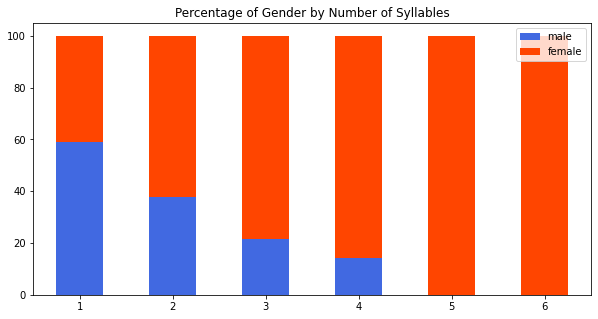

In [173]:
syllablesDF = pd.DataFrame.from_dict(syllables, orient='index')
syllablesDF = syllablesDF.sort_index()
syllablesDF.plot.bar(stacked=True, rot=0, color={"male": "royalblue", "female": "orangered"}, figsize=(10,5))
plt.title('Percentage of Gender by Number of Syllables')
plt.savefig('Figure ' + str(fig_no) + '.png')
fig_no +=1

### Third Iteration of Model
Let's construct a new model using the features: 

*   Last Letter of the Name
*   Last Two Letters of the Name
*   Number of Syllables in the Name

In [174]:
# Modified Feature Set to use last letter, last two letters, and the number of syllables
trainsets = []
for index, row in train.iterrows():
  temp = gender_features(row['Name'])
  temp['last_twoletters'] = row['Name'][-2:]
  temp['noofsyllables'] = count_syllables(row['Name'])
  
  x = ( temp, row['Gender'] )
  trainsets.append(x)

# Snippet of the training set
print(trainsets[:10])

# The training set is used to train a new "naive Bayes" classifier.
classifier = nltk.NaiveBayesClassifier.train(trainsets)

# Top 10 Informative Features
classifier.show_most_informative_features(10)

[({'last_letter': 'a', 'last_twoletters': 'na', 'noofsyllables': 2}, 'female'), ({'last_letter': 'e', 'last_twoletters': 'ne', 'noofsyllables': 3}, 'female'), ({'last_letter': 'e', 'last_twoletters': 'ce', 'noofsyllables': 2}, 'female'), ({'last_letter': 'i', 'last_twoletters': 'ti', 'noofsyllables': 2}, 'female'), ({'last_letter': 'a', 'last_twoletters': 'na', 'noofsyllables': 3}, 'female'), ({'last_letter': 'e', 'last_twoletters': 'te', 'noofsyllables': 2}, 'female'), ({'last_letter': 'r', 'last_twoletters': 'rr', 'noofsyllables': 1}, 'male'), ({'last_letter': 'n', 'last_twoletters': 'yn', 'noofsyllables': 3}, 'female'), ({'last_letter': 'a', 'last_twoletters': 'ha', 'noofsyllables': 3}, 'female'), ({'last_letter': 'e', 'last_twoletters': 'se', 'noofsyllables': 3}, 'female')]
Most Informative Features
         last_twoletters = 'na'           female : male   =    142.8 : 1.0
         last_twoletters = 'ia'           female : male   =     79.3 : 1.0
         last_twoletters = 'ta'    

In [175]:
# Run the classifier with the dev_test set
devtestsets = []
for index, row in devtest.iterrows():
  temp = gender_features(row['Name'])
  temp['last_twoletters'] = row['Name'][-2:]
  temp['noofsyllables'] = count_syllables(row['Name'])
  x = ( temp, row['Gender'] )
  devtestsets.append(x)

# Print the accuracy for the devtest set
print(nltk.classify.accuracy(classifier, devtestsets))

0.838


## Gender Percentage by First Letter
Let's further train the model by examining if the first letter has any observable phenomena for gender classification.

In [176]:
# Get list of unique last letters of each name
letters = set([])
for index, row in train.iterrows():
  if row['Name'][0].isalpha():
    letters.add(row['Name'][0])

# Convert letters to a list and sort it
letters = list(letters)
letters.sort()

# Create a quick dictionary to tally genders by last letter
firstletterGenders = {}
for letter in letters:
  firstletterGenders[letter] = {'male': 0, 'female': 0}
  subset = train[train['Name'].str[0] == letter]
  freq = subset.groupby('Gender').size().reset_index(name='counts')
  if 'male' in freq.values:
    firstletterGenders[letter]['male'] = freq.query('Gender == "male"')['counts'].iloc[0]
  if 'female' in freq.values:
    firstletterGenders[letter]['female'] = freq.query('Gender == "female"')['counts'].iloc[0]

# Convert values to percentages
for key in firstletterGenders.keys():
  total = firstletterGenders[key]['male'] + firstletterGenders[key]['female']
  firstletterGenders[key]['male'] = (firstletterGenders[key]['male'] / total) * 100
  firstletterGenders[key]['female'] = (firstletterGenders[key]['female'] / total) * 100


### Visualization of First Letter by Gender

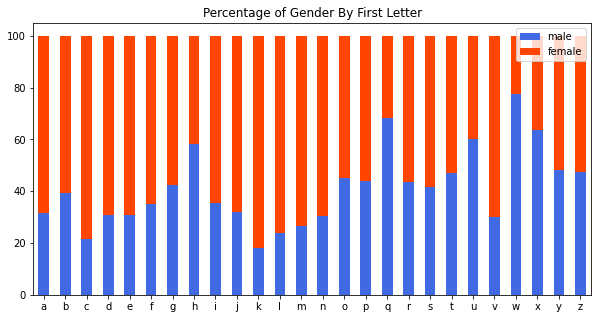

In [177]:
firstletterGendersDF = pd.DataFrame.from_dict(firstletterGenders, orient='index')
firstletterGendersDF.plot.bar(stacked=True, rot=0, color={"male": "royalblue", "female": "orangered"}, figsize=(10,5))
plt.title('Percentage of Gender By First Letter')
plt.savefig('Figure ' + str(fig_no) + '.png')
fig_no +=1

### Fourth Iteration of Model
Let's construct a new model using the features: 

*   Last Letter of the Name
*   Last Two Letters of the Name
*   Number of Syllables in the Name
*   First Letter of the Name

In [178]:
# Modified Feature Set to use last letter, last two letters, and the number of syllables
trainsets = []
for index, row in train.iterrows():
  temp = gender_features(row['Name'])
  temp['last_twoletters'] = row['Name'][-2:]
  temp['noofsyllables'] = count_syllables(row['Name'])
  temp['first_letter'] = row['Name'][0]

  x = ( temp, row['Gender'] )
  trainsets.append(x)

# Snippet of the training set
print(trainsets[:10])

# The training set is used to train a new "naive Bayes" classifier.
classifier = nltk.NaiveBayesClassifier.train(trainsets)

# Top 10 Informative Features
classifier.show_most_informative_features(10)

[({'last_letter': 'a', 'last_twoletters': 'na', 'noofsyllables': 2, 'first_letter': 'r'}, 'female'), ({'last_letter': 'e', 'last_twoletters': 'ne', 'noofsyllables': 3, 'first_letter': 'a'}, 'female'), ({'last_letter': 'e', 'last_twoletters': 'ce', 'noofsyllables': 2, 'first_letter': 'j'}, 'female'), ({'last_letter': 'i', 'last_twoletters': 'ti', 'noofsyllables': 2, 'first_letter': 'm'}, 'female'), ({'last_letter': 'a', 'last_twoletters': 'na', 'noofsyllables': 3, 'first_letter': 't'}, 'female'), ({'last_letter': 'e', 'last_twoletters': 'te', 'noofsyllables': 2, 'first_letter': 'b'}, 'female'), ({'last_letter': 'r', 'last_twoletters': 'rr', 'noofsyllables': 1, 'first_letter': 'b'}, 'male'), ({'last_letter': 'n', 'last_twoletters': 'yn', 'noofsyllables': 3, 'first_letter': 'r'}, 'female'), ({'last_letter': 'a', 'last_twoletters': 'ha', 'noofsyllables': 3, 'first_letter': 'j'}, 'female'), ({'last_letter': 'e', 'last_twoletters': 'se', 'noofsyllables': 3, 'first_letter': 'a'}, 'female')]
M

In [179]:
# Run the classifier with the dev_test set
devtestsets = []
for index, row in devtest.iterrows():
  temp = gender_features(row['Name'])
  temp['last_twoletters'] = row['Name'][-2:]
  temp['noofsyllables'] = count_syllables(row['Name'])
  temp['first_letter'] = row['Name'][0]
  x = ( temp, row['Gender'] )
  devtestsets.append(x)

# Print the accuracy for the devtest set
print(nltk.classify.accuracy(classifier, devtestsets))

0.848


## Sharp and Round Consonants in a Name

In the article [*What's in a Name? Sound Symbolism and Gender in First Names*](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4446333/) by David Sidhu and Penny Pexman, they studied gender and looked at sharp and round sounding phonemes (units of sound) in different names:

> Drawing on previous literature... we considered the consonants /b/, /l/, /m/ and /n/ to be round-sounding, and the consonants /k/, /p/ and /t/ to be sharp-sounding; in addition the vowels /u/, /o/ and /ɒ/ were considered round-sounding while the vowels /i/, /e/, /ɛ/ and /ʌ/ were considered sharp-sounding.

I made a table to translate the notation to [ARPAbet](https://en.wikipedia.org/wiki/ARPABET) notation.

**Round Sounding Consonants**  

|Article|ARPAbet|
|------|------|
|/l/  |L  |
|/m/  |M  |
|/n/  |N  |


**Sharp Sounding Consonants**  

|Article|ARPAbet|
|------|------|
|/k/  |K  |
|/p/  |P  |
|/t/  |T  |

**The ARPAbet**  

<img src=https://github.com/logicalschema/data620/raw/main/Project%203/data/phonemes.png width="150">



With the translation, I took the dataset of all the names and fed them to the [CMU Lexicon Tool](http://www.speech.cs.cmu.edu/tools/lextool.html). The tool converts words to phonemes and can give multiple forms for a single word. The dictionary is located [here](https://raw.githubusercontent.com/logicalschema/data620/main/Project%203/data/lextool/1499.dict). 

Here is an example for `Doris` which has 4 ways it can be pronounced:
```
DORIS	D AO R AH S
DORIS(2)	D AO R IH S
DORIS(3)	D AA R AH S
DORIS(4)	D AA R IH S
```

For this project, I decided to remove the multiple pronunciations. I will download the dictionary created by CMU for the names I submitted and count the number of round and sharp sounding consonants/vowels.


### CMU Data for the Name Set

In [180]:
file = urllib.request.urlopen('https://raw.githubusercontent.com/logicalschema/data620/main/Project%203/data/lextool/1499.dict')

name_cmu_dict = {}

# Split each line by the tab delimiter and add the phonemes to the name_cmu_dict. 
# The index will be the lowercase version of the name
for line in file:
  decoded_line = line.decode("utf-8")
  if '(' not in decoded_line:
    temp_list = decoded_line.strip().split('\t')
    temp_name = temp_list[0].lower()
    phoneme_list = temp_list[1].split(' ')
    name_cmu_dict[temp_name] = phoneme_list

# Snippet of name_cmu_dict
for name in list(name_cmu_dict)[:5]:
  print(name + " : " + str(name_cmu_dict[name]))


aamir : ['AA', 'M', 'AH', 'R']
aaron : ['EH', 'R', 'AH', 'N']
abagael : ['AE', 'B', 'AH', 'G', 'IY', 'L']
abagail : ['AH', 'B', 'AE', 'G', 'EY', 'L']
abbe : ['AE', 'B', 'IY']


### Visualization of Gender by Round and Sharp Sounds

In [181]:
# Round Sounding Phonemes
roundPhonemes = ['L', 'M', 'N']

# Sharp Sounding Phonemes
sharpPhonemes = ['K', 'P', 'T']

# rs_phonemes is a function that returns the count of round and soft phonemes in a word
# softPhonemes and roundPhonemes needs to be declared
# word needs to exist in name_cmu_dict
def rs_phonemes(word):
  temp = {'Round': 0, 'Sharp': 0}
  for phoneme in roundPhonemes:
    if phoneme in name_cmu_dict[word]:
      temp['Round'] = temp['Round'] + 1

  for phoneme in sharpPhonemes:
    if phoneme in name_cmu_dict[word]:
      temp['Sharp'] = temp['Sharp'] + 1

  return temp

# Tally of round and sharp phonemes 
tallyPhonemeDict = {'Gender': [], 'Round': [], 'Sharp': []}

# male names from Training Set
maleTDF = train[train['Gender'] == 'male']

# female names from Training Set
femaleTDF = train[train['Gender'] == 'female']

for index, row in maleTDF.iterrows():
  tempName = row['Name']
  temp = rs_phonemes(tempName)
  tallyPhonemeDict['Gender'].append('male')
  tallyPhonemeDict['Round'].append(temp['Round'])
  tallyPhonemeDict['Sharp'].append(temp['Sharp'])


for index, row in femaleTDF.iterrows():
  tempName = row['Name']
  temp = rs_phonemes(tempName)
  tallyPhonemeDict['Gender'].append('female')
  tallyPhonemeDict['Round'].append(temp['Round'])
  tallyPhonemeDict['Sharp'].append(temp['Sharp'])

plotDF = pd.DataFrame(data=tallyPhonemeDict)
plotDF.head()
plotDF.groupby('Gender').sum()

,Round,Sharp
Gender,,
female,4142,1566
male,1947,1011


### Fifth Iteration of Model
Let's construct a new model using the features: 

*   Last Letter of the Name
*   Last Two Letters of the Name
*   Number of Syllables in the Name
*   First Letter of the Name
*   Number of Round Consonant Phonemes
*   Number of Sharp Consonant Phonemes

In [182]:
# Modified Feature Set to use last letter, last two letters, and the number of syllables
trainsets = []
for index, row in train.iterrows():
  temp = gender_features(row['Name'])
  rs_dict = rs_phonemes(row['Name'])
  temp['last_twoletters'] = row['Name'][-2:]
  temp['noofsyllables'] = count_syllables(row['Name'])
  temp['first_letter'] = row['Name'][0]
  temp['round_consonants'] = rs_dict['Round']
  temp['sharp_consonants'] = rs_dict['Sharp']

  x = ( temp, row['Gender'] )
  trainsets.append(x)

# Snippet of the training set
print(trainsets[:10])

# The training set is used to train a new "naive Bayes" classifier.
classifier = nltk.NaiveBayesClassifier.train(trainsets)

# Top 10 Informative Features
classifier.show_most_informative_features(10)

[({'last_letter': 'a', 'last_twoletters': 'na', 'noofsyllables': 2, 'first_letter': 'r', 'round_consonants': 1, 'sharp_consonants': 0}, 'female'), ({'last_letter': 'e', 'last_twoletters': 'ne', 'noofsyllables': 3, 'first_letter': 'a', 'round_consonants': 2, 'sharp_consonants': 1}, 'female'), ({'last_letter': 'e', 'last_twoletters': 'ce', 'noofsyllables': 2, 'first_letter': 'j', 'round_consonants': 1, 'sharp_consonants': 0}, 'female'), ({'last_letter': 'i', 'last_twoletters': 'ti', 'noofsyllables': 2, 'first_letter': 'm', 'round_consonants': 1, 'sharp_consonants': 1}, 'female'), ({'last_letter': 'a', 'last_twoletters': 'na', 'noofsyllables': 3, 'first_letter': 't', 'round_consonants': 1, 'sharp_consonants': 1}, 'female'), ({'last_letter': 'e', 'last_twoletters': 'te', 'noofsyllables': 2, 'first_letter': 'b', 'round_consonants': 0, 'sharp_consonants': 1}, 'female'), ({'last_letter': 'r', 'last_twoletters': 'rr', 'noofsyllables': 1, 'first_letter': 'b', 'round_consonants': 0, 'sharp_conso

In [183]:
# Run the classifier with the dev_test set
devtestsets = []
for index, row in devtest.iterrows():
  temp = gender_features(row['Name'])
  temp['last_twoletters'] = row['Name'][-2:]
  temp['noofsyllables'] = count_syllables(row['Name'])
  temp['first_letter'] = row['Name'][0]
  temp['round_consonants'] = rs_dict['Round']
  temp['sharp_consonants'] = rs_dict['Sharp']

  x = ( temp, row['Gender'] )
  devtestsets.append(x)

# Print the accuracy for the devtest set
print(nltk.classify.accuracy(classifier, devtestsets))

0.848


## Initial Voiced Phoneme

In the article, [*The Voiced Pronunciation of Initial Phonemes Predicts theGender of Names*](http://www.columbia.edu/~ms4992/Pubs/2016_Slepian-Galinsky_JPSP.pdf) by Michael Slepian and Adam Galinsky, they observed gender classification by looking at the first voiced or unvoiced phoneme of the name.

The following is a table that organizes voiced and unvoiced by letter according to Slepian and Galinsky:

<img src=https://github.com/logicalschema/data620/raw/main/Project%203/data/initialphoneme.png width="400">

Because we have already examined the first letter in the name, I will add this feature to the model.

### Sixth Iteration of Model

Let's construct a new model using the features: 

*   Last Letter of the Name
*   Last Two Letters of the Name
*   Number of Syllables in the Name
*   First Letter of the Name
*   Number of Round Consonant Phonemes
*   Number of Sharp Consonant Phonemes
*   Presence of Initial Voiced Phoneme



In [184]:
# is_initial_voiced function returns 1 if the 1st letter is voiced otherwise 0
# Assumes word is lowercase 
def is_initial_voiced(word):
  if word[0] in ['c', 'f', 'h', 'k', 'p', 'q', 's', 't']:
    return 0
  else:
    return 1

# Modified Feature Set to use last letter, last two letters, and the number of syllables
trainsets = []
for index, row in train.iterrows():
  temp = gender_features(row['Name'])
  rs_dict = rs_phonemes(row['Name'])
  temp['last_twoletters'] = row['Name'][-2:]
  temp['noofsyllables'] = count_syllables(row['Name'])
  temp['first_letter'] = row['Name'][0]
  temp['round_consonants'] = rs_dict['Round']
  temp['sharp_consonants'] = rs_dict['Sharp']
  temp['is_initial_voiced'] = is_initial_voiced(row['Name'])

  x = ( temp, row['Gender'] )
  trainsets.append(x)

# Snippet of the training set
print(trainsets[:10])

# The training set is used to train a new "naive Bayes" classifier.
classifier = nltk.NaiveBayesClassifier.train(trainsets)

# Top 10 Informative Features
classifier.show_most_informative_features(10)

[({'last_letter': 'a', 'last_twoletters': 'na', 'noofsyllables': 2, 'first_letter': 'r', 'round_consonants': 1, 'sharp_consonants': 0, 'is_initial_voiced': 1}, 'female'), ({'last_letter': 'e', 'last_twoletters': 'ne', 'noofsyllables': 3, 'first_letter': 'a', 'round_consonants': 2, 'sharp_consonants': 1, 'is_initial_voiced': 1}, 'female'), ({'last_letter': 'e', 'last_twoletters': 'ce', 'noofsyllables': 2, 'first_letter': 'j', 'round_consonants': 1, 'sharp_consonants': 0, 'is_initial_voiced': 1}, 'female'), ({'last_letter': 'i', 'last_twoletters': 'ti', 'noofsyllables': 2, 'first_letter': 'm', 'round_consonants': 1, 'sharp_consonants': 1, 'is_initial_voiced': 1}, 'female'), ({'last_letter': 'a', 'last_twoletters': 'na', 'noofsyllables': 3, 'first_letter': 't', 'round_consonants': 1, 'sharp_consonants': 1, 'is_initial_voiced': 0}, 'female'), ({'last_letter': 'e', 'last_twoletters': 'te', 'noofsyllables': 2, 'first_letter': 'b', 'round_consonants': 0, 'sharp_consonants': 1, 'is_initial_voi

In [185]:
# Run the classifier with the dev_test set
devtestsets = []
for index, row in devtest.iterrows():
  temp = gender_features(row['Name'])
  temp['last_twoletters'] = row['Name'][-2:]
  temp['noofsyllables'] = count_syllables(row['Name'])
  temp['first_letter'] = row['Name'][0]
  temp['round_consonants'] = rs_dict['Round']
  temp['sharp_consonants'] = rs_dict['Sharp']
  temp['is_initial_voiced'] = is_initial_voiced(row['Name'])

  x = ( temp, row['Gender'] )
  devtestsets.append(x)

# Print the accuracy for the devtest set
print(nltk.classify.accuracy(classifier, devtestsets))

0.848


## Number of Consonants and Vowels

### Seventh Iteration of Model

Let's construct a new model using the features: 

*   Last Letter of the Name
*   Last Two Letters of the Name
*   Number of Syllables in the Name
*   First Letter of the Name
*   Number of Round Consonant Phonemes
*   Number of Sharp Consonant Phonemes
*   Presence of Initial Voiced Phoneme
*   Number of Consonants
*   Number of Vowels



In [186]:
# count_vowels_consonants returns the number of vowels and consonants in the word
# Assumes the word is lowercase
def count_vowels_consonants(word):
  temp = word.replace(' ', '')
  v_count = 0
  for s in temp:
    if s in 'aeiouy':
      v_count = v_count + 1
  
  return v_count, len(temp) - v_count

# Modified Feature Set to use last letter, last two letters, and the number of syllables
trainsets = []
for index, row in train.iterrows():
  temp = gender_features(row['Name'])
  rs_dict = rs_phonemes(row['Name'])
  temp['last_twoletters'] = row['Name'][-2:]
  temp['noofsyllables'] = count_syllables(row['Name'])
  temp['first_letter'] = row['Name'][0]
  temp['round_consonants'] = rs_dict['Round']
  temp['sharp_consonants'] = rs_dict['Sharp']
  temp['is_initial_voiced'] = is_initial_voiced(row['Name'])
  temp['noofvowels'], temp['noofconsonants'] = count_vowels_consonants(row['Name'])

  x = ( temp, row['Gender'] )
  trainsets.append(x)

# Snippet of the training set
print(trainsets[:10])

# The training set is used to train a new "naive Bayes" classifier.
classifier = nltk.NaiveBayesClassifier.train(trainsets)

# Top 10 Informative Features
classifier.show_most_informative_features(10)


[({'last_letter': 'a', 'last_twoletters': 'na', 'noofsyllables': 2, 'first_letter': 'r', 'round_consonants': 1, 'sharp_consonants': 0, 'is_initial_voiced': 1, 'noofvowels': 2, 'noofconsonants': 2}, 'female'), ({'last_letter': 'e', 'last_twoletters': 'ne', 'noofsyllables': 3, 'first_letter': 'a', 'round_consonants': 2, 'sharp_consonants': 1, 'is_initial_voiced': 1, 'noofvowels': 4, 'noofconsonants': 3}, 'female'), ({'last_letter': 'e', 'last_twoletters': 'ce', 'noofsyllables': 2, 'first_letter': 'j', 'round_consonants': 1, 'sharp_consonants': 0, 'is_initial_voiced': 1, 'noofvowels': 3, 'noofconsonants': 3}, 'female'), ({'last_letter': 'i', 'last_twoletters': 'ti', 'noofsyllables': 2, 'first_letter': 'm', 'round_consonants': 1, 'sharp_consonants': 1, 'is_initial_voiced': 1, 'noofvowels': 2, 'noofconsonants': 3}, 'female'), ({'last_letter': 'a', 'last_twoletters': 'na', 'noofsyllables': 3, 'first_letter': 't', 'round_consonants': 1, 'sharp_consonants': 1, 'is_initial_voiced': 0, 'noofvowe

In [187]:
# Run the classifier with the dev_test set
devtestsets = []
for index, row in devtest.iterrows():
  temp = gender_features(row['Name'])
  temp['last_twoletters'] = row['Name'][-2:]
  temp['noofsyllables'] = count_syllables(row['Name'])
  temp['first_letter'] = row['Name'][0]
  temp['round_consonants'] = rs_dict['Round']
  temp['sharp_consonants'] = rs_dict['Sharp']
  temp['is_initial_voiced'] = is_initial_voiced(row['Name'])
  temp['noofvowels'], temp['noofconsonants'] = count_vowels_consonants(row['Name'])


  x = ( temp, row['Gender'] )
  devtestsets.append(x)

# Print the accuracy for the devtest set
print(nltk.classify.accuracy(classifier, devtestsets))

0.842


With the reduced accuracy, I decided to remove the number of vowels and consonants features from the model.

## Counting Phonemes


In [188]:
arpabet = ['AA','AE','AH','AO','AW','AY','B','CH','D','DH','EH','ER','EY','F','G','HH','IH','IY','JH','K','L','M','N','NG','OW','OY','P','R','S','SH','T','TH','UH','UW','V','W','Y','Z','ZH']

# count_phonemes returns a dictionary of the individual counts for phonemes from the ARPAbet
def count_phonemes(word):
  count_phonemes = {}

  # Initialize the dictionary
  for phoneme in arpabet:
    count_phonemes[phoneme] = 0
  
  for i in name_cmu_dict[word]:
    count_phonemes[i] = count_phonemes[i] + 1

  return count_phonemes

# Example of the function
print(count_phonemes('joellyn'))

{'AA': 0, 'AE': 0, 'AH': 1, 'AO': 0, 'AW': 0, 'AY': 0, 'B': 0, 'CH': 0, 'D': 0, 'DH': 0, 'EH': 1, 'ER': 0, 'EY': 0, 'F': 0, 'G': 0, 'HH': 0, 'IH': 0, 'IY': 0, 'JH': 1, 'K': 0, 'L': 1, 'M': 0, 'N': 1, 'NG': 0, 'OW': 1, 'OY': 0, 'P': 0, 'R': 0, 'S': 0, 'SH': 0, 'T': 0, 'TH': 0, 'UH': 0, 'UW': 0, 'V': 0, 'W': 0, 'Y': 0, 'Z': 0, 'ZH': 0}


### Eighth Iteration of Model

Let's construct a new model using the features: 

*   Last Letter of the Name
*   Last Two Letters of the Name
*   Number of Syllables in the Name
*   First Letter of the Name
*   Number of Round Consonant Phonemes
*   Number of Sharp Consonant Phonemes
*   Presence of Initial Voiced Phoneme
*   ARPAbet Phoneme Count

In [189]:
# Modified Feature Set to use last letter, last two letters, and the number of syllables
trainsets = []
for index, row in train.iterrows():
  temp = gender_features(row['Name'])
  rs_dict = rs_phonemes(row['Name'])
  temp['last_twoletters'] = row['Name'][-2:]
  temp['noofsyllables'] = count_syllables(row['Name'])
  temp['first_letter'] = row['Name'][0]
  temp['round_consonants'] = rs_dict['Round']
  temp['sharp_consonants'] = rs_dict['Sharp']
  temp['is_initial_voiced'] = is_initial_voiced(row['Name'])
  temp_count_phoneme = count_phonemes(row['Name'])
  for p in arpabet:
    temp[p] = temp_count_phoneme[p]

  x = ( temp, row['Gender'] )
  trainsets.append(x)

# Snippet of the training set
print(trainsets[:3])

# The training set is used to train a new "naive Bayes" classifier.
classifier = nltk.NaiveBayesClassifier.train(trainsets)

# Top 10 Informative Features
classifier.show_most_informative_features(10)

[({'last_letter': 'a', 'last_twoletters': 'na', 'noofsyllables': 2, 'first_letter': 'r', 'round_consonants': 1, 'sharp_consonants': 0, 'is_initial_voiced': 1, 'AA': 0, 'AE': 0, 'AH': 1, 'AO': 0, 'AW': 0, 'AY': 0, 'B': 0, 'CH': 0, 'D': 0, 'DH': 0, 'EH': 0, 'ER': 0, 'EY': 0, 'F': 0, 'G': 0, 'HH': 0, 'IH': 0, 'IY': 1, 'JH': 0, 'K': 0, 'L': 0, 'M': 0, 'N': 1, 'NG': 0, 'OW': 0, 'OY': 0, 'P': 0, 'R': 1, 'S': 0, 'SH': 0, 'T': 0, 'TH': 0, 'UH': 0, 'UW': 0, 'V': 0, 'W': 0, 'Y': 0, 'Z': 0, 'ZH': 0}, 'female'), ({'last_letter': 'e', 'last_twoletters': 'ne', 'noofsyllables': 3, 'first_letter': 'a', 'round_consonants': 2, 'sharp_consonants': 1, 'is_initial_voiced': 1, 'AA': 0, 'AE': 0, 'AH': 1, 'AO': 0, 'AW': 0, 'AY': 1, 'B': 0, 'CH': 0, 'D': 0, 'DH': 0, 'EH': 1, 'ER': 0, 'EY': 0, 'F': 0, 'G': 0, 'HH': 0, 'IH': 0, 'IY': 0, 'JH': 0, 'K': 1, 'L': 1, 'M': 0, 'N': 1, 'NG': 0, 'OW': 0, 'OY': 0, 'P': 0, 'R': 0, 'S': 1, 'SH': 0, 'T': 0, 'TH': 0, 'UH': 0, 'UW': 0, 'V': 0, 'W': 0, 'Y': 0, 'Z': 0, 'ZH': 0}, 

In [190]:
# Run the classifier with the dev_test set
devtestsets = []
for index, row in devtest.iterrows():
  temp = gender_features(row['Name'])
  temp['last_twoletters'] = row['Name'][-2:]
  temp['noofsyllables'] = count_syllables(row['Name'])
  temp['first_letter'] = row['Name'][0]
  temp['round_consonants'] = rs_dict['Round']
  temp['sharp_consonants'] = rs_dict['Sharp']
  temp['is_initial_voiced'] = is_initial_voiced(row['Name'])
  temp_count_phoneme = count_phonemes(row['Name'])
  for p in arpabet:
    temp[p] = temp_count_phoneme[p]

  x = ( temp, row['Gender'] )
  devtestsets.append(x)

# Print the accuracy for the devtest set
print(nltk.classify.accuracy(classifier, devtestsets))

0.848


## Final Model

The final model will use these features: 

*   Last Letter of the Name
*   Last Two Letters of the Name
*   Number of Syllables in the Name
*   First Letter of the Name
*   Number of Round Consonant Phonemes
*   Number of Sharp Consonant Phonemes
*   Presence of Initial Voiced Phoneme
*   ARPAbet Phoneme Count

The function for finding the features of the model is below.

In [191]:
# Final Feature Function calls gender_features
# Returns a dictionary
def features(word):
  temp = gender_features(word)
  temp['last_twoletters'] = word[-2:]
  temp['noofsyllables'] = count_syllables(word)
  temp['first_letter'] = word[0]
  temp['round_consonants'] = rs_dict['Round']
  temp['sharp_consonants'] = rs_dict['Sharp']
  temp['is_initial_voiced'] = is_initial_voiced(word)
  temp_count_phoneme = count_phonemes(word)
  for p in arpabet:
    temp[p] = temp_count_phoneme[p]

  return temp



### Running the test set with the final model

In [192]:
# Run the classifier with the test set
testsets = []
for index, row in test.iterrows():
  temp = features(row['Name'])
  x = ( temp, row['Gender'] )
  testsets.append(x)

# Print the accuracy for the devtest set
print(nltk.classify.accuracy(classifier, testsets))

0.824


# Remember the Unisex Set
This section uses the classifier on the unisex set of names from the beginning. Because the set can be either male or female, I wanted to see how the model would classify these names.

In [208]:
unisexClassification = {}

# Use the classifier and store the values in a dictionary
for name in unisex:
  unisexClassification[name] = classifier.classify(gender_features(name))

print(list(unisexClassification.items())[:10])


[('van', 'male'), ('page', 'female'), ('ginger', 'male'), ('deane', 'female'), ('sibyl', 'male'), ('frank', 'male'), ('christie', 'female'), ('heath', 'female'), ('maurise', 'female'), ('dennie', 'female')]


# Conclusion
Modeling is very powerful and able to assist in classifying names. I would be interested in improving the model by being able to include additional features like open and closed syllables. Classification can be controversial as well in this day and age of gender dysphoria. Gender classification of names can quickly become controversial and context is important.